In [3]:
import json
import folium
import math
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from osgeo import ogr
    
from mpl_toolkits.basemap import Basemap
from numpy import array
from matplotlib.path import Path
import matplotlib.patches as patches
%matplotlib inline
driver = ogr.GetDriverByName("OpenFileGDB")

ds = driver.Open("/Users/rishuvaid/Desktop/data/Zone19_2009_01.gdb", 0)




In [4]:
min_x= -71.1392
min_y=42.6026
max_x=-70.3633
max_y=42.2102
map = Basemap(llcrnrlon=min_x ,llcrnrlat=max_y,urcrnrlon=max_x,urcrnrlat=min_y,resolution='c',projection='tmerc',lat_0=29.40,lon_0=-68.83)


minx,miny=map(min_x,min_y,inverse=False)
maxx,maxy=map(max_x,max_y,inverse=False)
layerr=ds.GetLayer()
ex_tent=[minx,miny,maxx,maxy]
    
    
layerr.SetSpatialFilterRect(min_x,min_y,max_x,max_y)
#layerr.SetAttributeFilter("BaseDateTime > '2009/01/07 00:00:00' AND BaseDateTime < '2009/01/15 00:00:00'")






In [5]:
layerr.SetAttributeFilter("VoyageID < '100'")
voyage_arrays={}
universal_cords=[[],[]]
for feat in layerr:
    geom = feat.GetGeometryRef()
    universal_cords[0].append(geom.GetX())
    universal_cords[1].append(geom.GetY())
    if feat.GetField("VoyageID") not in voyage_arrays:
        voyage_arrays[feat.GetField("VoyageID")]=[[geom.GetX()],[geom.GetY()],[feat.GetField("BaseDateTime")]]
    else:
        voyage_arrays[feat.GetField("VoyageID")][0].append(geom.GetX())
        voyage_arrays[feat.GetField("VoyageID")][1].append(geom.GetY())
        voyage_arrays[feat.GetField("VoyageID")][2].append(feat.GetField("BaseDateTime"))


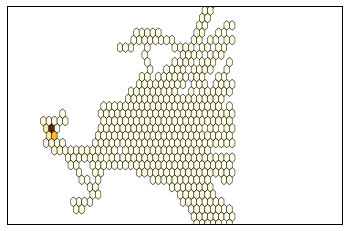

In [6]:
x,y=map(universal_cords[0],universal_cords[1])
hex_bin=map.hexbin(array(x),array(y),gridsize=40,linewidths=0.5, edgecolors='k',cmap='YlOrBr', mincnt=1,extent=ex_tent)
hexbin_offset=hex_bin.get_offsets()
hexbin_paths=hex_bin.get_paths()[0]

cordinates=list(hexbin_paths.iter_segments())
hex_collection={"type":"FeatureCollection"}
hex_collection['features']=[]
for i,x in enumerate(hexbin_offset):
    binx,biny=x[0],x[1]
    cord_arr=[]
    hex_cord={}
    for cord in cordinates:
    
        cords=[]
        cord_x=float(cord[0][0])+float(binx)
        cord_y=float(cord[0][1])+float(biny)
        lon,lat=map(cord_x,cord_y,inverse=True)
        cords.append(lon)
        cords.append(lat)
        cord_arr.append(cords)
    hex_cord["id"]=i
    hex_cord["type"]="Feature"
    hex_cord["geometry"]={"type":"Polygon"}
    hex_cord["properties"]={}
    hex_cord["properties"]["count1"]=0
    hex_cord["properties"]["count2"]=0
    hex_cord["properties"]["count3"]=0
    hex_cord["properties"]["count4"]=0
    hex_cord["geometry"]["coordinates"]=[cord_arr]
    hex_collection['features'].append(hex_cord)



In [7]:
def calculate_initial_compass_bearing(pointA, pointB):
    
    if (type(pointA) != tuple) or (type(pointB) != tuple):
        raise TypeError("Only tuples are supported as arguments")

    lat1 = math.radians(pointA[0])
    lat2 = math.radians(pointB[0])

    diffLong = math.radians(pointB[1] - pointA[1])

    x = math.sin(diffLong) * math.cos(lat2)
    y = math.cos(lat1) * math.sin(lat2) - (math.sin(lat1)
            * math.cos(lat2) * math.cos(diffLong))

    initial_bearing = math.atan2(x, y)

    # Now we have the initial bearing but math.atan2 return values
    # from -180° to + 180° which is not what we want for a compass bearing
    # The solution is to normalize the initial bearing as shown below
    initial_bearing = math.degrees(initial_bearing)
    compass_bearing = (initial_bearing + 360) % 360

    return compass_bearing

#Referred to: Jeromer,2012, Retreived from: https://gist.github.com/jeromer/2005586

In [8]:
voyage_keys=list(voyage_arrays.keys())
for hexagon in hex_collection['features']:
    ring = ogr.Geometry(ogr.wkbLinearRing)
    for hex_cordinates in hexagon['geometry']['coordinates'][0]:
        ring.AddPoint(hex_cordinates[0],hex_cordinates[1])
    poly = ogr.Geometry(ogr.wkbPolygon)
    poly.AddGeometry(ring)
    
    for voyage in voyage_arrays:
        for i in range(len(voyage_arrays[voyage][0])):
            if((i!=len(voyage_arrays[voyage][0])-1) and ((voyage_arrays[voyage][0][i]!=voyage_arrays[voyage][0][i+1]) and (voyage_arrays[voyage][1][i+1]!=voyage_arrays[voyage][1][i]))):
        
                line = ogr.Geometry(ogr.wkbLineString)
                line.AddPoint(voyage_arrays[voyage][0][i],voyage_arrays[voyage][1][i])
                line.AddPoint(voyage_arrays[voyage][0][i+1],voyage_arrays[voyage][1][i+1])
                
                find=poly.Intersects(line)
                bearing=0
              
                if(find==True):
                    if(voyage_arrays[voyage][2][i+1]>voyage_arrays[voyage][2][i]):
                        pointA=(voyage_arrays[voyage][1][i],voyage_arrays[voyage][0][i])
                        pointB=(voyage_arrays[voyage][1][i+1],voyage_arrays[voyage][0][i+1])
                        bearing=calculate_initial_compass_bearing(pointA,pointB)

                    else:
                        pointB=(voyage_arrays[voyage][1][i],voyage_arrays[voyage][0][i])
                        pointA=(voyage_arrays[voyage][1][i+1],voyage_arrays[voyage][0][i+1])
                        bearing=calculate_initial_compass_bearing(pointA,pointB)
                    #print(bearing)
                    if(bearing>=0 and bearing <=90):
                        hexagon['properties']['count1']+=1
                    if(bearing>90 and bearing <=180):
                        hexagon['properties']['count2']+=1
                    if(bearing>180 and bearing <=270):
                        hexagon['properties']['count3']+=1
                    if(bearing>270 and bearing <=360):
                        hexagon['properties']['count4']+=1
     
                
#print(hex_collection)                            
            
        
    
    

In [9]:
from IPython.core.display import HTML
def inline_map(m, width=950, height=800):
    """Takes a folium instance and embed HTML."""
    m.choropleth
    srcdoc = m.HTML.replace('"', '&quot;')
    
    embed = HTML('<iframe srcdoc="{}" '
                 'style="width: {}px; height: {}px; '
                 'border: none"></iframe>'.format(srcdoc, width, height))
    return embed

with open('Jan_dir_90.geojson', 'w') as outfile:
    json.dump(hex_collection, outfile)

In [11]:

data_90 = pd.DataFrame([[feature['id'],feature['properties']['count1']] for feature in hex_collection['features']], columns=['FID','DIRCOUNT'])

data_180 = pd.DataFrame([[feature['id'],feature['properties']['count2']] for feature in hex_collection['features']], columns=['FID','DIRCOUNT'])

data_270 = pd.DataFrame([[feature['id'],feature['properties']['count3']] for feature in hex_collection['features']], columns=['FID','DIRCOUNT'])

data_360 = pd.DataFrame([[feature['id'],feature['properties']['count4']] for feature in hex_collection['features']], columns=['FID','DIRCOUNT'])
  

m1=data_90['DIRCOUNT'].max()
m2=data_180['DIRCOUNT'].max()
m3=data_270['DIRCOUNT'].max()
m4=data_360['DIRCOUNT'].max()


max_data=max([m1,m2,m3,m4])
min_data=min([data_90['DIRCOUNT'].min(),data_180['DIRCOUNT'].min(),data_270['DIRCOUNT'].min(),data_360['DIRCOUNT'].min()])

interval=5000
thresh = [min_data + val*interval for val in range(int((max_data-min_data)/interval))]







     FID  DIRCOUNT
0      0     26875
1      1        31
2      2     42890
3      3      3513
4      4      1039
5      5      1224
6      6      1787
7      7        47
8      8         4
9      9       245
10    10       602
11    11       719
12    12         2
13    13       316
14    14       649
15    15       280
16    16       316
17    17         5
18    18       272
19    19       447
20    20        90
21    21        19
22    22       216
23    23         0
24    24         0
25    25       564
26    26         0
27    27        98
28    28         1
29    29       147
..   ...       ...
449  449         0
450  450         1
451  451         5
452  452        13
453  453         0
454  454        12
455  455         0
456  456        82
457  457         0
458  458         0
459  459         0
460  460         0
461  461         6
462  462        13
463  463         0
464  464        14
465  465      2762
466  466         0
467  467         0
468  468         0
469  469    

In [24]:
######################   FOR DISPLAY   #######################

dcmap2=folium.Map(location=[min_y,min_x])
dcmap2.geo_json(geo_path='Jan_dir_90.geojson',key_on='feature.id',
    data=data_90,threshold_scale=[100,500,1000,2000,4000,6000],
    columns=['FID','DIRCOUNT'],
    fill_color='YlOrRd')
dcmap2.geo_json(geo_path='Jan_dir_90.geojson',key_on='feature.id',
    data=data_180,threshold_scale=[100,500,1000,2000,4000,6000],
    columns=['FID','DIRCOUNT'],
    fill_color='YlOrRd')
dcmap2.geo_json(geo_path='Jan_dir_90.geojson',key_on='feature.id',
    data=data_270,threshold_scale=[100,500,1000,2000,4000,6000],
    columns=['FID','DIRCOUNT'],
    fill_color='YlOrRd')
dcmap2.geo_json(geo_path='Jan_dir_90.geojson',key_on='feature.id',
    data=data_360,threshold_scale=[100,500,1000,2000,4000,6000],
    columns=['FID','DIRCOUNT'],
    fill_color='YlOrRd')



#dcmap2.lat_lng_popover()
dcmap2.create_map(path='demo_direction1.html')
#dcmap2



/Users/rishuvaid/anaconda/lib/python3.4/site-packages/folium/folium.py:504: UserWarning: This method is deprecated. Please use Map.choropleth instead.
  warnings.warn('This method is deprecated. '
/Users/rishuvaid/anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:22: FutureWarning: Map.create_map is deprecated. Use Map.save instead
